Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


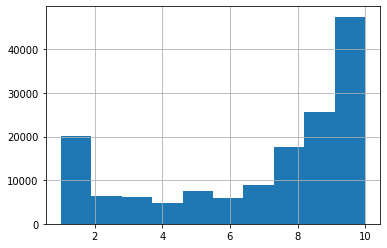

In [0]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
%matplotlib inline

filename = "TheFinalDuck/WellCookedDuck"

# %%
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/ZMUM/"

df = pd.read_csv(f'{root_dir}no_abbreviations_Train.csv')
df = df[['opinion', 'rate']]

train = df
train['rate'].hist()

train_samp = train.sample(frac = 1.0, random_state = 123)

embed_size = 200 
max_features = 20000
maxlen = 200

embedding_file = f'{root_dir}glove.twitter.27B.200d.txt'

def get_coefs(word,*arr): 
  return word, np.asarray(arr, dtype='float32')
    
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file, encoding="utf8"))

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['opinion'].values))

with open(f'{root_dir}{filename}-tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X_train = tokenizer.texts_to_sequences(train_samp['opinion'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
y_train = train_samp['rate'].values

word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [0]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(420, return_sequences=True))(x)
x = Bidirectional(GRU(420, return_sequences=True))(x)
x = SpatialDropout1D(0.4)(x)
avg_pool = GlobalAveragePooling1D()(x)  
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
hidden = Dense(120, activation = 'elu')(conc)
outp = Dense(1)(hidden)

model = Model(inputs = inp, outputs = outp)

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = f'{root_dir}{filename}-new.hdf5')
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae'])
print(model.summary())
model.load_weights(f'{root_dir}{filename}.hdf5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 200)     4000000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 200, 200)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200, 840)     2086560     spatial_dropout1d_3[0][0]        
____________________________________________________________________________________________

In [0]:
np.save(f'{root_dir}{filename}-x_train.npy', x_train)
np.save(f'{root_dir}{filename}-y_train.npy', y_train)


In [0]:
def lr_schedule(epoch):
    lrate = 1e-6
    if epoch > 8:
        lrate = lrate/2
    if epoch > 15:
        lrate = lrate/2
    if epoch > 20:
        lrate = lrate/2
    return lrate

history = model.fit(x_train, y_train, batch_size = 512, epochs = 30, validation_split = 0.1,
          callbacks=[earlystop, checkpoint, LearningRateScheduler(lr_schedule)])

hist_df = pd.DataFrame(history.history)

model_json = model.to_json()
with open(f'{root_dir}{filename}-model.json', 'w+') as json_file:
    json_file.write(model_json)
with open(f'{root_dir}{filename}-history.json', 'w+') as f:
    hist_df.to_json(f)
model.save_weights(f'{root_dir}{filename}-end_model.h5') 

Train on 135000 samples, validate on 15000 samples
Epoch 1/30
135000/135000 [==============================] - 461s 3ms/step - loss: 0.5057 - mae: 0.5057 - val_loss: 0.8489 - val_mae: 0.8489
Epoch 2/30
 60416/135000 [============>.................] - ETA: 4:07 - loss: 0.5075 - mae: 0.5075